In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, betabinom
from scipy.optimize import brentq
import itertools
import seaborn as sns

# First, visualize the distribution of coverage

You will never actually see this distribution in real-life, because it assumes an infinite validation set.
However, it helps you pick $n$.

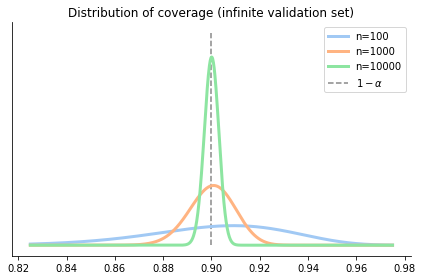

In [ ]:
ns = [100,1000,10000]
alpha = 0.1

sns.set_palette('pastel')
plt.figure()
ax = plt.gca()

for i in range(len(ns)):
  n = ns[i]
  l = np.floor((n+1)*alpha)
  a = n + 1 - l
  b = l
  x = np.linspace(0.825,0.975,1000)
  rv = beta(a, b)
  ax.plot(x, rv.pdf(x), lw=3, label=f'n={n}')
ax.vlines(1-alpha,ymin=0,ymax=150,color='#888888',linestyles='dashed',label=r'$1-\alpha$')
sns.despine(top=True,right=True)
plt.yticks([])
plt.legend()
plt.title('Distribution of coverage (infinite validation set)')
plt.tight_layout()
plt.savefig('./beta.pdf')

# Choosing $n$ to achieve a coverage error of $\epsilon$

All we need to do is invert the Beta CDF.

In [ ]:
alpha = 0.1
epsilons = [0.1,0.05,0.01,0.005,0.001]
for epsilon in epsilons:
  def _condition(n):
    l = np.floor((n+1)*alpha)
    a = n + 1 - l
    b = l
    if (beta.ppf(0.05, a, b) < 1-alpha-epsilon) or (beta.ppf(0.95, a, b) > 1-alpha+epsilon):
      return -1
    else:
      return 1

  print(int(np.ceil(brentq(_condition,np.ceil(1/alpha),100000000000))))


22
102
2491
9812
244390


# Next, the distribution of empirical coverage with a finite validation set

This is what you see when you run conformal prediction 1000 times over different random splits of your data and then make a histogram of the coverage values.  Notice that as $n' \to \infty$, the distribution converges to the Beta distribution in the earlier cell.

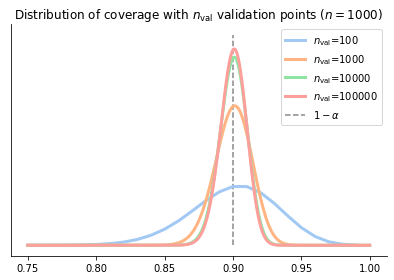

In [ ]:
n = 1000
nprimes = [100,1000,10000,100000]
alpha = 0.1

sns.set_palette('pastel')
plt.figure()
ax = plt.gca()

# Beta parameters
l = np.floor((n+1)*alpha)
a = n + 1 - l
b = l

for i in range(len(nprimes)):
  nprime = nprimes[i]
  x = np.array(range(int(nprime*(0.75)),nprime))
  rv = betabinom(nprime,a, b)
  # Renormalize the pmf to account for the larger number of points.
  ax.plot(x/nprime, rv.pmf(x) * nprime/nprimes[0], lw=3, label=r"$n_{\rm val}$" + f'={nprime}')

ax.vlines(1-alpha,ymin=0,ymax=0.45,color='#888888',linestyles='dashed',label=r'$1-\alpha$')
sns.despine(top=True,right=True)
plt.yticks([])
plt.legend()
plt.title(r"Distribution of coverage with $n_{\rm val}$ validation points ($n=1000$)")
plt.tight_layout()
plt.savefig('./betabinom.pdf')

# Finally, the distribution of average empirical coverage

This is what you see when you run conformal prediction 1000 times over different random splits of your data and then take the average of the 1000 coverages.

In [ ]:
# parameters
alpha = 0.1
ns = [100,1000,10000]
nprimes = [100,1000,10000]
params = [(n,nprime) for n in ns for nprime in nprimes]
Rs = [100, 1000, 10000]
T = 1000
list_distributions = []
for R in Rs:
  distributions = []
  for param in params:
    n = param[0]
    nprime = param[1]
    l = np.floor((n+1)*alpha)
    a = n + 1 - l
    b = l

    distribution = np.zeros((T,))
    for t in range(T):
      samples = betabinom.rvs(nprime, a, b, size=R)/nprime
      distribution[t] = samples.mean()
    distributions = distributions + [distribution,]
  list_distributions = list_distributions + [distributions,]

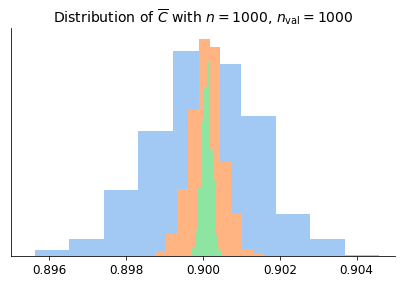

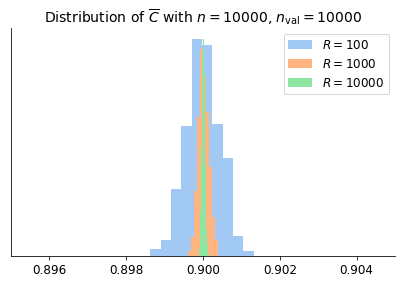

In [ ]:
# Plot
toPlots = [4,8]
for toPlot in toPlots:
  plt.figure()
  ax = plt.gca()
  sns.set_palette('pastel')
  for i in range(len(Rs)):
    distributions = list_distributions[i]
    ax.hist(distributions[toPlot],label=r'$R=$'+str(Rs[i]))
  sns.despine(ax=ax,top=True, right=True)
  plt.title(r"Distribution of $\overline{C}$ with $n=$"+str(params[toPlot][0])+r", $n_{\rm val}=$"+str(params[toPlot][1]), fontsize=14)
  if toPlot == toPlots[-1]:
    plt.legend(fontsize=12)
  plt.tight_layout()
  plt.xticks(fontsize=12)
  plt.yticks([])
  plt.xlim([0.895,0.905])
  plt.savefig(f'./{str(params[toPlot][0])}-{str(params[toPlot][1])}-average-empirical-coverage.pdf')
  plt.show()